<h1 style='color: green; font-size: 36px; font-weight: bold;'>Exploratory Data Analysis: Brasilian houses to rent</h1>

## Importando Bibliotecas

In [2]:
# Import das bibliotecas e setting de configurações 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)

%matplotlib inline
plt.rc('figure', figsize = (14, 6))

## Leitura dos dados

Importando o dataset "houses_to_rent_analisado", onde já foi realizado tratamento dos dados:

In [3]:
dataset = pd.read_csv('houses_to_rent_analisado.csv', sep=',')

In [4]:
dataset.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,São Paulo,70,2,1,1,7,0,0,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,0,1,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,0,1,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,0,1,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,1,1,0,800,25,11,836


## Correlações entre as variáveis 

<AxesSubplot:>

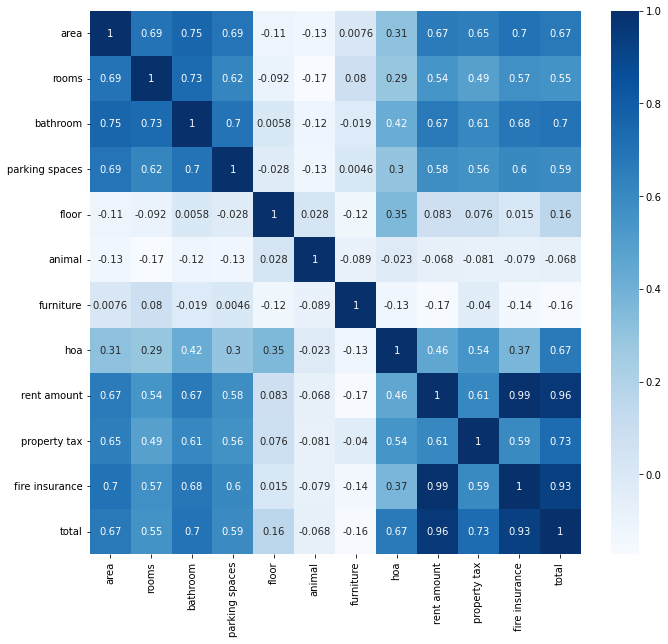

In [5]:
corr = dataset.drop(['city'], axis=1).corr()

plt.figure(figsize=(11,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="Blues", annot=True)

Todas as outras colunas apresentam correlações positivas, ou seja, uma relação diretamente proporcional entre as variáveis, menos as colunas floor, animal e furniture.

## Overview

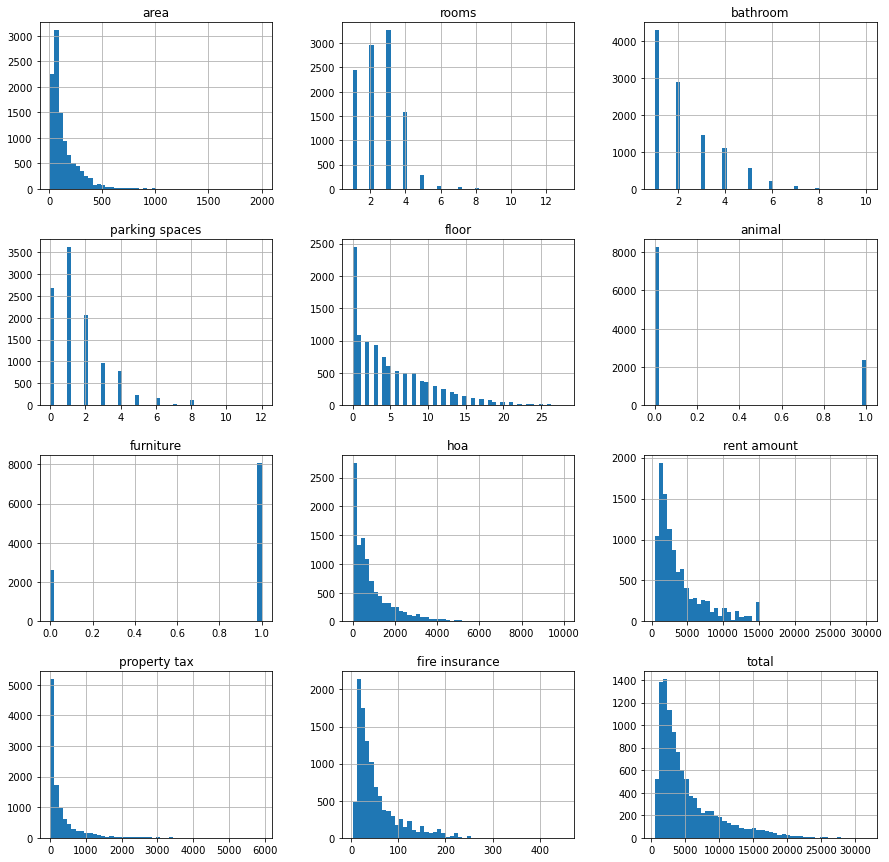

In [6]:
histograma = dataset.hist(bins=50, figsize=(15, 15))

## Exploratory Data Analysis

###  Verificando Algumas Hipóteses

- Influência do animal nos valores do aluguel do imóvel
- Inpacto dos imóveis serem monbiliados sobre o valor do aluguel 
- Influência do andar sobre os alugueis dos imóveis dos apartamentos (a partir do 1 andar)
- Influência da localização (cidade) sobre os alugueis dos imóveis

### Influência do animal (aceitar ou não) nos valores médios do aluguel do imóvel

In [34]:
quant_animal_por_cidade = dataset.groupby(['city', 'animal'])['total'].count().round(2).reset_index()
quant_animal_por_cidade.replace({0: 'Aceita', 1: 'Não aceita'}, inplace=True)
quant_animal_por_cidade.rename({'total': 'quantidade'}, axis=1, inplace=True)
quant_animal_por_cidade

,city,animal,quantidade
0,Belo Horizonte,Aceita,927
1,Belo Horizonte,Não aceita,325
2,Campinas,Aceita,691
3,Campinas,Não aceita,160
4,Porto Alegre,Aceita,1004
5,Porto Alegre,Não aceita,188
6,Rio de Janeiro,Aceita,1203
7,Rio de Janeiro,Não aceita,296
8,São Paulo,Aceita,4469
9,São Paulo,Não aceita,1397


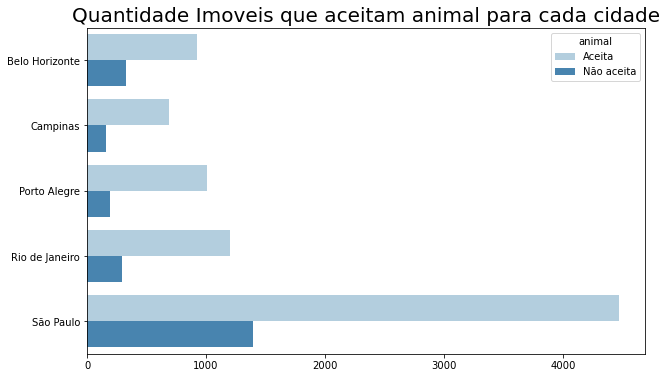

In [35]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='quantidade', y='city', hue='animal', data=quant_animal_por_cidade, orient='h', palette='Blues')
barras.set_title('Quantidade Imoveis que aceitam animal para cada cidade', fontdict={'fontsize': 20})
barras.set(ylabel=None, xlabel=None)
plt.show()

In [ ]:
media_animal = dataset.groupby('animal')['total'].mean().to_frame()
media_animal.rename(index={0: 'Aceita', 1: 'Não Aceita'}, columns={'total': 'Média dos alugueis'}, inplace=True)
media_animal

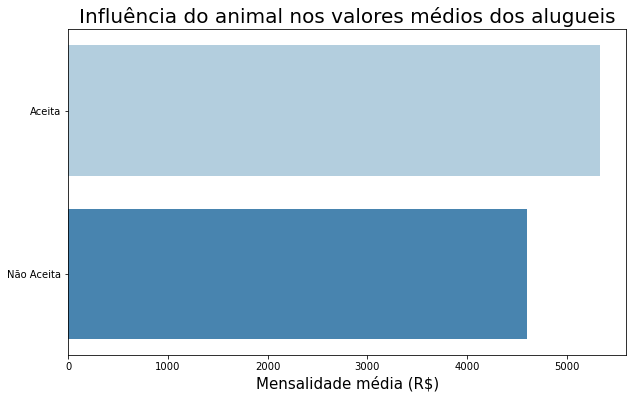

In [8]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x=media_animal['Média dos alugueis'], y=media_animal.index, data=media_animal, orient='h', palette='Blues')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência do animal nos valores médios dos alugueis', fontdict={'fontsize': 20})
barras.set(ylabel=None)
plt.show()

In [9]:
media_animal_por_cidade = dataset.groupby(['city', 'animal'])['total'].mean().round(2).reset_index()
media_animal_por_cidade.replace({0: 'Aceita', 1: 'Não aceita'}, inplace=True)
media_animal_por_cidade

,city,animal,total
0,Belo Horizonte,Aceita,4719.46
1,Belo Horizonte,Não aceita,3898.72
2,Campinas,Aceita,3300.27
3,Campinas,Não aceita,2631.56
4,Porto Alegre,Aceita,2987.38
5,Porto Alegre,Não aceita,2844.34
6,Rio de Janeiro,Aceita,4577.00
7,Rio de Janeiro,Não aceita,4352.07
8,São Paulo,Aceita,6502.58
9,São Paulo,Não aceita,5290.52


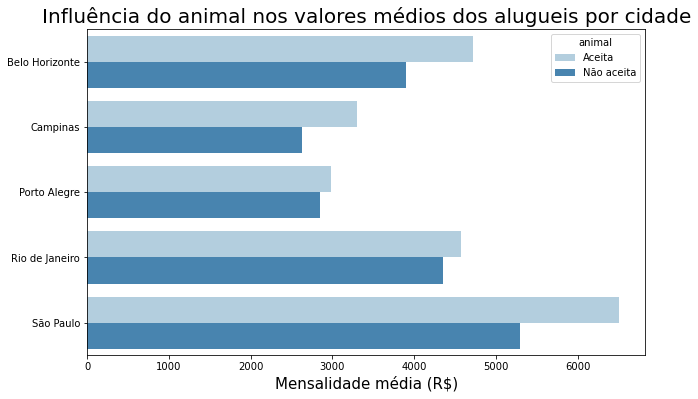

In [10]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='total', y='city', hue='animal', data=media_animal_por_cidade, orient='h', palette='Blues')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência do animal nos valores médios dos alugueis por cidade', fontdict={'fontsize': 20})
barras.set(ylabel=None)
plt.show()

Em média, imóveis que aceitam animais são mais caros em todas as cidades. A cidade de São Paulo possui a maior discrepância de valor dentre as cidades.

### Inpacto dos imóveis serem monbiliados sobre o valor do aluguel

In [37]:
quant_mobiliada_por_cidade = dataset.groupby(['city', 'furniture'])['total'].count().round(2).reset_index()
quant_mobiliada_por_cidade.replace({0:'Mobiliada', 1: 'Não mobiliada'}, inplace=True)
quant_mobiliada_por_cidade.rename({'total': 'quantidade'}, axis=1, inplace=True)
quant_mobiliada_por_cidade

,city,furniture,quantidade
0,Belo Horizonte,Mobiliada,175
1,Belo Horizonte,Não mobiliada,1077
2,Campinas,Mobiliada,111
3,Campinas,Não mobiliada,740
4,Porto Alegre,Mobiliada,319
5,Porto Alegre,Não mobiliada,873
6,Rio de Janeiro,Mobiliada,405
7,Rio de Janeiro,Não mobiliada,1094
8,São Paulo,Mobiliada,1589
9,São Paulo,Não mobiliada,4277


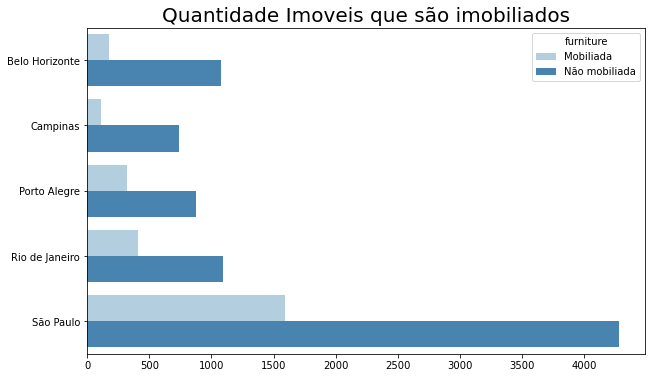

In [38]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='quantidade', y='city', hue='furniture', data=quant_animal_por_cidade, orient='h', palette='Blues')
barras.set_title('Quantidade Imoveis que são imobiliados', fontdict={'fontsize': 20})
barras.set(ylabel=None, xlabel=None)
plt.show()

In [11]:
media_mobilia = dataset.groupby('furniture')['total'].mean().round(2).to_frame()
media_mobilia.rename(index={0:'Mobiliada', 1: 'Não mobiliada'}, columns={'total': 'Média dos alugueis'}, inplace=True)
media_mobilia

,Média dos alugueis
furniture,
Mobiliada,6453.97
Não mobiliada,4757.35


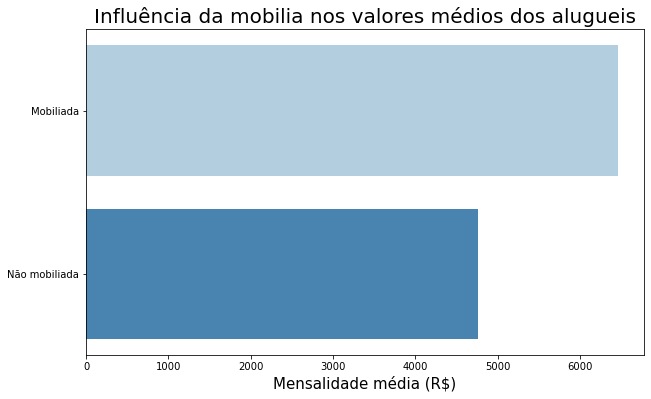

In [12]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='Média dos alugueis', y=media_mobilia.index, data=media_mobilia, orient='h', palette='Blues')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência da mobilia nos valores médios dos alugueis', fontdict={'fontsize': 20})
barras.set(ylabel=None)
plt.show()

In [13]:
media_mobilia_por_cidade = dataset.groupby(['city', 'furniture'])['total'].mean().round(2).reset_index()
media_mobilia_por_cidade.replace({0:'Mobiliada', 1: 'Não mobiliada'}, inplace=True)
media_mobilia_por_cidade

,city,furniture,total
0,Belo Horizonte,Mobiliada,5876.19
1,Belo Horizonte,Não mobiliada,4283.84
2,Campinas,Mobiliada,3808.92
3,Campinas,Não mobiliada,3079.38
4,Porto Alegre,Mobiliada,3818.61
5,Porto Alegre,Não mobiliada,2652.84
6,Rio de Janeiro,Mobiliada,5788.32
7,Rio de Janeiro,Não mobiliada,4067.71
8,São Paulo,Mobiliada,7401.09
9,São Paulo,Não mobiliada,5772.87


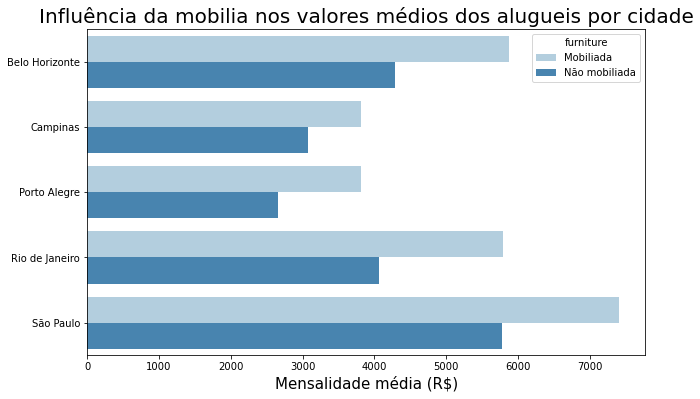

In [14]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='total', y='city', hue='furniture', data=media_mobilia_por_cidade, orient='h', palette='Blues')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência da mobilia nos valores médios dos alugueis por cidade', fontdict={'fontsize': 20})
barras.set(ylabel=None)

# for container in barras.containers:
#     barras.bar_label(container)

plt.show()

Em média, imóveis mobiliadosmais são caros em todas as cidades. A cidade de São Paulo possui a maior discrepância de valor dentre as cidades.

### Influência do andar sobre os alugueis dos imóveis dos apartamentos (a partir do 1 andar)


In [15]:
media_andar = dataset[dataset['floor'] > 0].groupby('floor')['total'].mean().to_frame()
media_andar['Quantidade'] = dataset.groupby('floor')['floor'].count()
media_andar

,total,Quantidade
floor,,
1,3922.533828,1079
2,3781.795939,985
3,4052.591398,930
4,4539.942359,746
5,5130.663333,600
6,4990.102612,536
7,5457.405242,496
8,5731.457143,490
9,5854.314363,369


Devido a pouca quantidade de informações dos andares supeiores a 22, vamos removelos da análise:

In [16]:
# Selecionando os andares que possui ocorrencia maior que 40
andares = media_andar.query('Quantidade > 40')

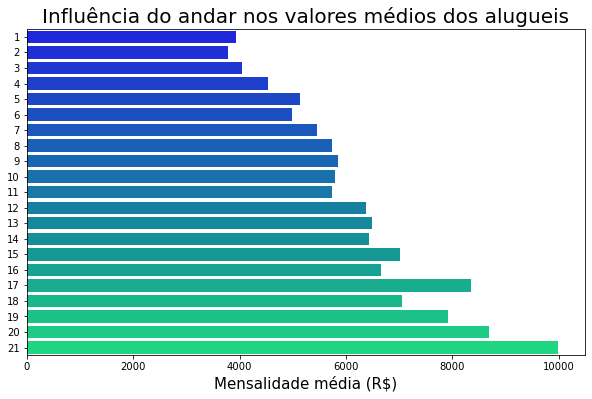

In [17]:
plt.figure(figsize=(10, 6))
barras = sns.barplot(x='total', y=andares.index, data=andares, orient='h', palette='winter')
barras.set_xlabel('Mensalidade média (R$)', fontdict={'fontsize': 15})
barras.set_title('Influência do andar nos valores médios dos alugueis', fontdict={'fontsize': 20})
barras.set(ylabel=None)
plt.show()

É possível perceber uma tendencia de aumento nos valores dos alugueis com o aumento dos andares. As possíveis explicações de acordo com os especialista são a vista e quantidade de ruídos. Um apartamento no andar mais alto proporciona uma melhor vista. Uma menor quantidade de ruídos vindos da rua faz com que os andares superiores sejam os preferidos dos moradores.

### Influência da localização (cidade) sobre os custos de aluguéis

Utilizando a função cut do pandas para segmentar e classificar valores totais:

In [18]:
intervalos_total = pd.cut(dataset.total, [0, 1500, 3000, 4500, 6000, 7500, 10000, np.inf])
intervalos_total[:3]

0     (4500.0, 6000.0]
1    (7500.0, 10000.0]
2     (3000.0, 4500.0]
Name: total, dtype: category
Categories (7, interval[float64, right]): [(0.0, 1500.0] < (1500.0, 3000.0] < (3000.0, 4500.0] < (4500.0, 6000.0] < (6000.0, 7500.0] < (7500.0, 10000.0] < (10000.0, inf]]

Criando um novo dataframe com as infomações dos intervalos:

In [49]:
df_intervalos = pd.DataFrame({'intervalo_total': intervalos_total,
                                'area': dataset['area'],
                                'quartos': dataset['rooms'],
                                'condominio': dataset['hoa'],
                                'IPTU': dataset['property tax'],
                                'aluguel': dataset['rent amount'],
                                'seguro_incendio': dataset['fire insurance'],
                                'cidades': dataset['city']
                                })

In [21]:
medias_areas_por_cidade = df_intervalos.pivot_table(values='area',       # coluna agregada
                                                    index='intervalo_total',    # Intervalo que serão agregados os valores
                                                    columns='cidades',   # colunas
                                                    aggfunc='mean').round(2)    # função que irá ser execultada para agrupar os valores
medias_areas_por_cidade

cidades,Belo Horizonte,Campinas,Porto Alegre,Rio de Janeiro,São Paulo
intervalo_total,,,,,
"(0.0, 1500.0]",58.15,55.79,49.65,41.08,47.32
"(1500.0, 3000.0]",95.83,83.53,74.34,62.82,66.34
"(3000.0, 4500.0]",158.83,142.98,133.70,94.23,100.62
"(4500.0, 6000.0]",231.87,195.49,189.79,117.29,137.74
"(6000.0, 7500.0]",283.08,257.71,243.70,140.47,174.41
"(7500.0, 10000.0]",340.05,342.82,316.52,185.24,224.81
"(10000.0, inf]",370.02,422.05,353.32,273.11,313.44


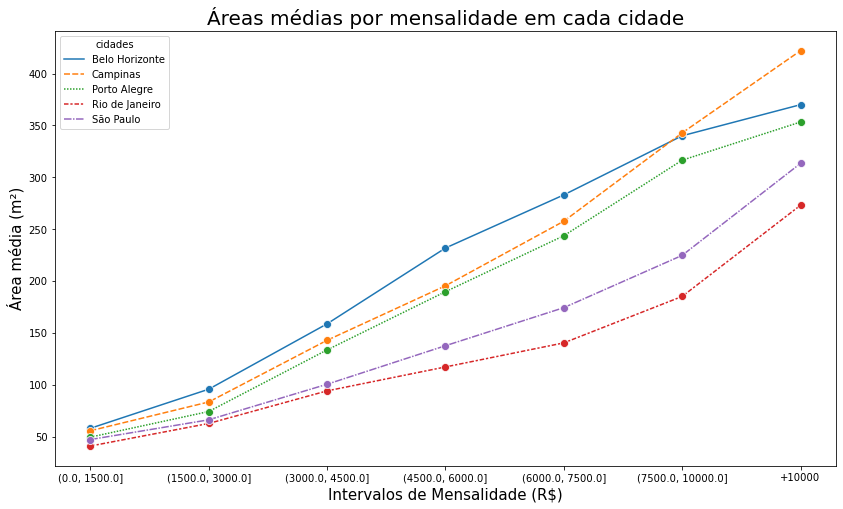

In [22]:
medias_areas_por_cidade = medias_areas_por_cidade.reset_index() # forma de corrigir o erro ao utilizar o df no lineplot
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=medias_areas_por_cidade, marker='o', markersize=8)
x1.set_ylabel('Área média (m²)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Mensalidade (R$)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(medias_areas_por_cidade['intervalo_total'][:-1]) + ['+10000'])
x1.set_title('Áreas médias por mensalidade em cada cidade', fontdict={'fontsize': 20})
plt.show()

O aumento da área implica no aumento do custo total de aluguel, o que confirma correlação positiva entre as features. O Rio de Janeiro é a cidade que possui a menor média de área para todas as classes de mensalidade, enquanto Belo Horizonte possui a maior média de área para as classes até R$10000,00.

In [23]:
medias_IPTU_por_cidade = df_intervalos.pivot_table(values='IPTU',       # coluna agregada
                                                    index='intervalo_total',    # Intervalo que serão agregados os valores
                                                    columns='cidades',   # colunas
                                                    aggfunc='mean').round(2)   # função que irá ser execultada para agrupar os valores
medias_IPTU_por_cidade

cidades,Belo Horizonte,Campinas,Porto Alegre,Rio de Janeiro,São Paulo
intervalo_total,,,,,
"(0.0, 1500.0]",42.65,32.81,32.50,28.12,30.16
"(1500.0, 3000.0]",109.88,82.96,73.44,71.56,62.94
"(3000.0, 4500.0]",225.97,182.22,142.12,173.50,150.81
"(4500.0, 6000.0]",308.33,294.72,336.62,268.34,294.01
"(6000.0, 7500.0]",423.97,363.29,369.00,334.42,439.56
"(7500.0, 10000.0]",538.70,425.09,494.85,567.34,681.14
"(10000.0, inf]",821.47,705.03,603.37,873.87,1236.78


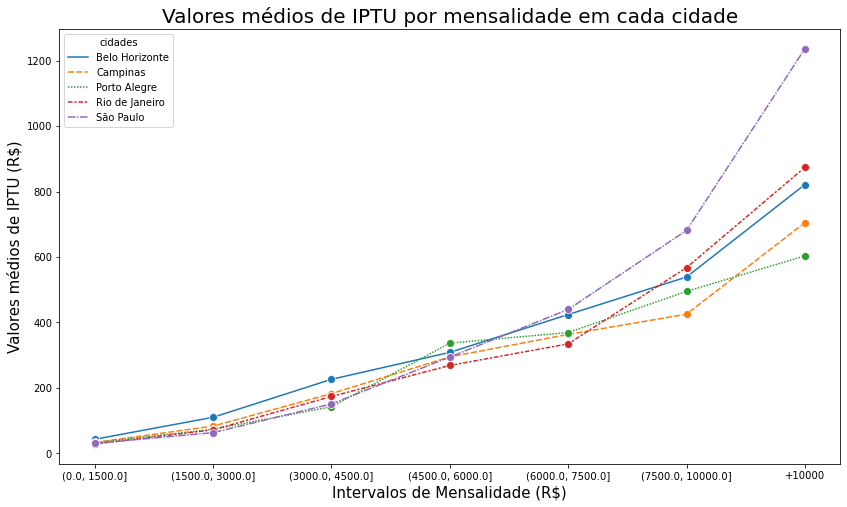

In [24]:
medias_IPTU_por_cidade = medias_IPTU_por_cidade.reset_index() # forma de corrigir o erro ao utilizar o df no lineplot
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=medias_IPTU_por_cidade, marker='o', markersize=8)
x1.set_ylabel('Valores médios de IPTU (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Mensalidade (R$)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(medias_IPTU_por_cidade['intervalo_total'][:-1]) + ['+10000'])
x1.set_title('Valores médios de IPTU por mensalidade em cada cidade', fontdict={'fontsize': 20})
plt.show()

### Composição do preço total para a cidade de São Paulo por intervalo de preço

Escolhendo a cidade de São Paulo para analise, já que a cidade com maior número de informções. Separando novamente as infomações em um dataset por intervalos de alugueis anterioremente divididos e agrupando as informações através das médias dos dados de cada intervalo.

In [129]:
composicao_aluguel = df_intervalos.pivot_table(values=['condominio', 'IPTU', 'aluguel', 'seguro_incendio'],       # coluna agregada
                                                    index='intervalo_total',    # Intervalo que serão agregados os valores
                                                    columns='cidades',   # colunas
                                                    aggfunc='mean').round(2)   # função que irá ser execultada para agrupar os valores
composicao_aluguel

IPTU                                       \
cidades           Belo Horizonte Campinas Porto Alegre Rio de Janeiro   
intervalo_total                                                         
(0.0, 1500.0]              42.65    32.81        32.50          28.12   
(1500.0, 3000.0]          109.88    82.96        73.44          71.56   
(3000.0, 4500.0]          225.97   182.22       142.12         173.50   
(4500.0, 6000.0]          308.33   294.72       336.62         268.34   
(6000.0, 7500.0]          423.97   363.29       369.00         334.42   
(7500.0, 10000.0]         538.70   425.09       494.85         567.34   
(10000.0, inf]            821.47   705.03       603.37         873.87   

                                   aluguel                         \
cidades           São Paulo Belo Horizonte  Campinas Porto Alegre   
intervalo_total                                                     
(0.0, 1500.0]         30.16         957.52    856.09       901.06   
(1500.0, 3000.0]      62.94        1608.89   1490.77      1654.79   
(3000.0, 4500.0]     150.81        2825.27   2746.24      2844.24   
(4500.0, 6000.0]     294.01        4121.77   3905.67      4111.06   
(6000.0, 7500.0]     439.56        5296.59   5176.67      5451.97   
(7500.0, 10000.0]    681.14        7130.90   6699.71      7060.37   
(10000.0, inf]      1236.78       11847.62  10124.47     11400.50   

                                               condominio           \
cidades           Rio de Janeiro São Paulo Belo Horizonte Campinas   
intervalo_total                                                      
(0.0, 1500.0]             855.11   1050.38         145.73   312.95   
(1500.0, 3000.0]         1543.33   1782.69         333.52   512.65   
(3000.0, 4500.0]         2568.77   2885.40         532.30   687.37   
(4500.0, 6000.0]         3602.03   3822.57         636.70   909.25   
(6000.0, 7500.0]         4759.15   4891.18         867.14  1004.83   
(7500.0, 10000.0]        6091.62   6321.31         949.41  1452.44   
(10000.0, inf]          10534.80  10580.34        1342.03  2059.29   

                                                        seguro_incendio  \
cidades           Porto Alegre Rio de Janeiro São Paulo  Belo Horizonte   
intervalo_total                                                           
(0.0, 1500.0]           226.05         239.46     52.52           13.57   
(1500.0, 3000.0]        397.91         557.87    400.32           22.47   
(3000.0, 4500.0]        595.70         903.45    645.82           40.25   
(4500.0, 6000.0]        752.78        1293.51    989.18           60.77   
(6000.0, 7500.0]        767.55        1567.98   1260.51           79.62   
(7500.0, 10000.0]      1129.44        1937.81   1591.87          107.69   
(10000.0, inf]         1382.32        2594.90   2458.80          175.75   

                                                                  
cidades           Campinas Porto Alegre Rio de Janeiro São Paulo  
intervalo_total                                                   
(0.0, 1500.0]        11.47        13.96          11.66     15.00  
(1500.0, 3000.0]     19.82        24.95          20.33     23.75  
(3000.0, 4500.0]     37.73        43.75          33.70     38.56  
(4500.0, 6000.0]     54.25        65.10          47.16     51.41  
(6000.0, 7500.0]     72.29        89.76          62.23     65.52  
(7500.0, 10000.0]    94.68       113.22          79.12     85.30  
(10000.0, inf]      140.29       184.32         139.16    141.63

Plotando o gráfico da composição dos valores médios de custo por mensalidade para a cidade de São Paulo

<Figure size 1080x720 with 0 Axes>

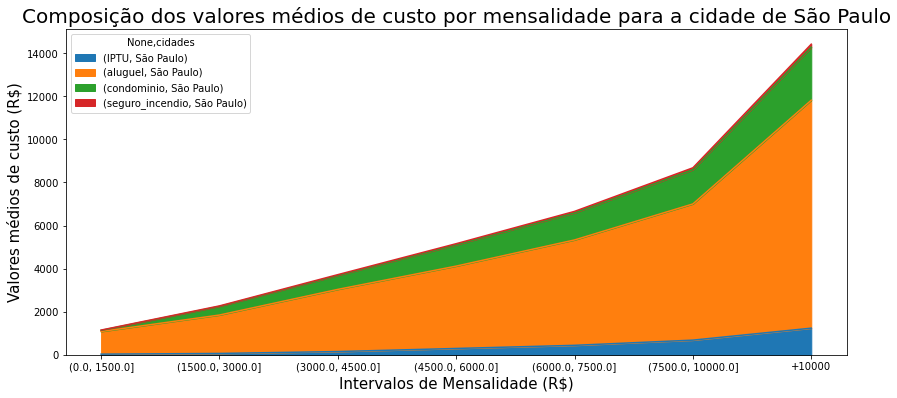

In [130]:
composicao_aluguel = composicao_aluguel.reset_index()
plt.figure(figsize=(15, 10))
x1 = composicao_aluguel.iloc[:,5::5].plot.area()
x1.set_ylabel('Valores médios de custo (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Mensalidade (R$)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(composicao_aluguel['intervalo_total'][:-1]) + ['+10000'])
x1.set_title('Composição dos valores médios de custo por mensalidade para a cidade de São Paulo', fontdict={'fontsize': 20})
plt.show()

In [69]:
df_cidade_SP = df_intervalos.query('cidades == "São Paulo"')

In [85]:
composicao_aluguel_SP = df_cidade_SP.pivot_table(values=['condominio', 'IPTU', 'aluguel', 'seguro_incendio'],
                                    index='intervalo_total',
                                    aggfunc='mean').round(2).reset_index()

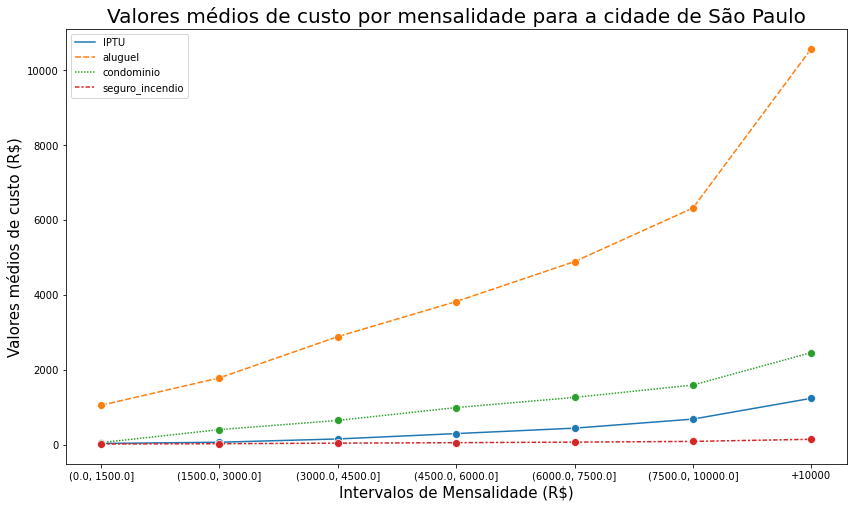

In [90]:
plt.figure(figsize=(14, 8))
x1 = sns.lineplot(data=composicao_aluguel_SP, marker='o', markersize=8)
x1.set_ylabel('Valores médios de custo (R$)', fontdict={'fontsize': 15})
x1.set_xlabel('Intervalos de Mensalidade (R$)', fontdict={'fontsize': 15})
x1.set_xticklabels([0] + list(medias_IPTU_por_cidade['intervalo_total'][:-1]) + ['+10000'])
x1.set_title('Valores médios de custo por mensalidade para a cidade de São Paulo', fontdict={'fontsize': 20})
plt.show()